# Import the data from xlsx 

In [57]:
import openpyxl
import datetime
import numpy as np
# Open the workbook and select the first worksheet
wb = openpyxl.load_workbook('wordle_data.xlsx')
sh = wb['Sheet1']
# List to hold dates
date_list = []
word_list = []
normal_people_list = []
hard_people_list = []
overall_percent_list = []

#Iterate through each row in worksheet and fetch values into dict
#value starts at row 3

for row in range(3, sh.max_row + 1):
    # Each row in the spreadsheet has data for one date
	date = sh.cell(row=row, column=1).value
	# if the date is none, then break the loop
	if date is None:
		break
	word = sh.cell(row=row, column=3).value
	normal_people = sh.cell(row=row, column=4).value
	hard_people = sh.cell(row=row, column=5).value
	# normal_people as float 
	normal_people = float(normal_people)
	hard_people = float(hard_people)
	# F to L as a list, then append the list to overall_percent_list
	daily_percent = [sh.cell(row=row, column=i).value for i in range(6, 12)]
	

	# Append the date and value to the appropriate list
	# Convert the date string into a datetime object.
	date = datetime.datetime.strptime(date, "%m/%d/%Y")
	date_list.append(date)
	word_list.append(word)
	normal_people_list.append(normal_people)
	hard_people_list.append(hard_people)
	overall_percent_list.append(daily_percent)
 
# inverse all lists into chronological order
date_list.reverse()
word_list.reverse()
normal_people_list.reverse()
hard_people_list.reverse()
overall_percent_list.reverse()


# normal_people_list = np.array(normal_people_list).astype(float)
# hard_people_list = np.array(hard_people_list).astype(float)
# hard_ratio = hard_people_list/normal_people_list





## Truncate data from peak

/tmp/ipykernel_58852/149024154.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


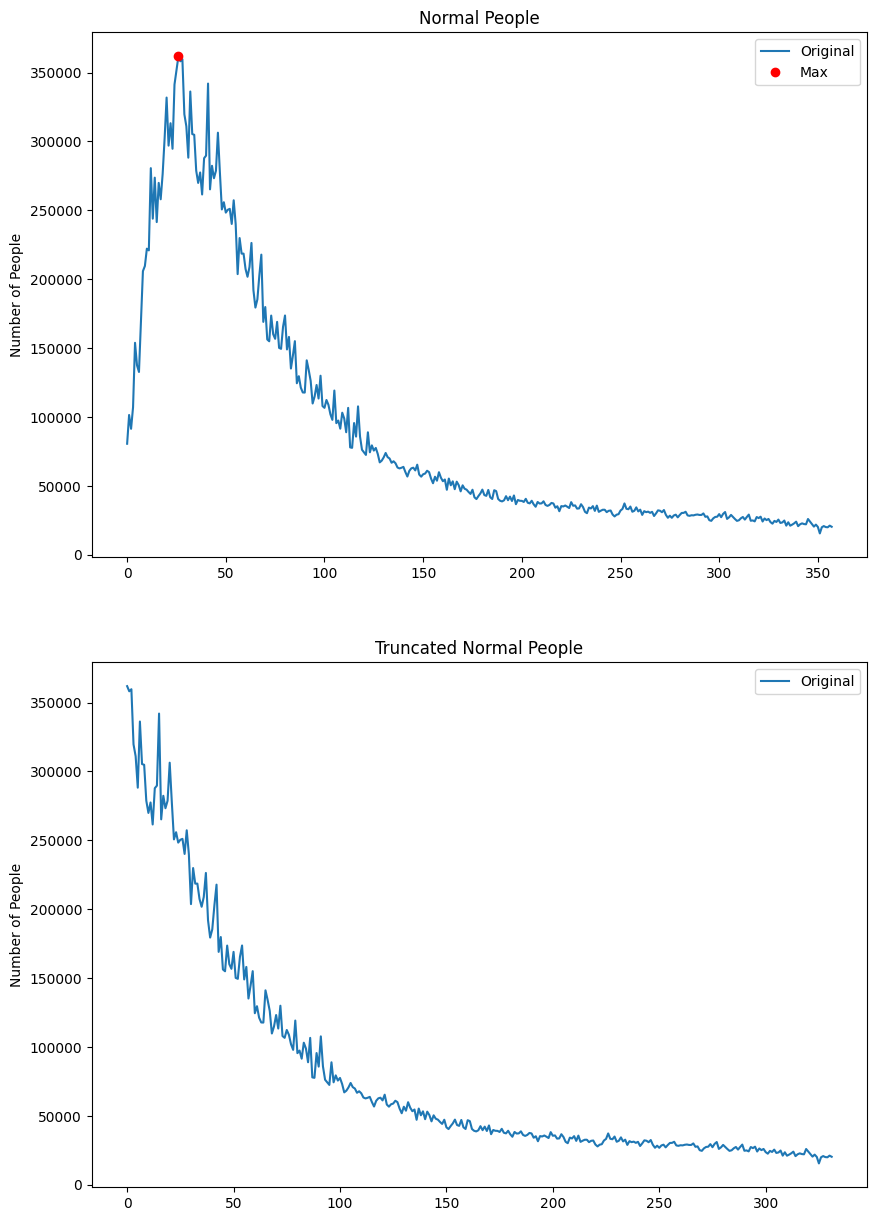

In [58]:
max = 0.
max_index = 0.
#find max value and index of normal_people_list
for i in range(len(normal_people_list)):
	if normal_people_list[i] > max:
		max = normal_people_list[i]
		max_index = i
	


# #only mark the max value point on the normal_people_list
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))
ax1.plot(normal_people_list, label='Original')
ax1.plot(max_index, normal_people_list[max_index], 'ro', label='Max')
ax1.title.set_text('Normal People')
ax1.set_ylabel('Number of People')
ax1.legend()
 
# Truncate the normal_people_list from the max value to the end
truncated_people_list = normal_people_list[max_index:]
t = np.arange(len(truncated_people_list))

ax2.plot(truncated_people_list, label='Original')
ax2.title.set_text('Truncated Normal People')
ax2.set_ylabel('Number of People')
ax2.legend()
fig.show()
	

## Smooth data


7752.475905063618
564.4986287246154


/tmp/ipykernel_58852/3930745555.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


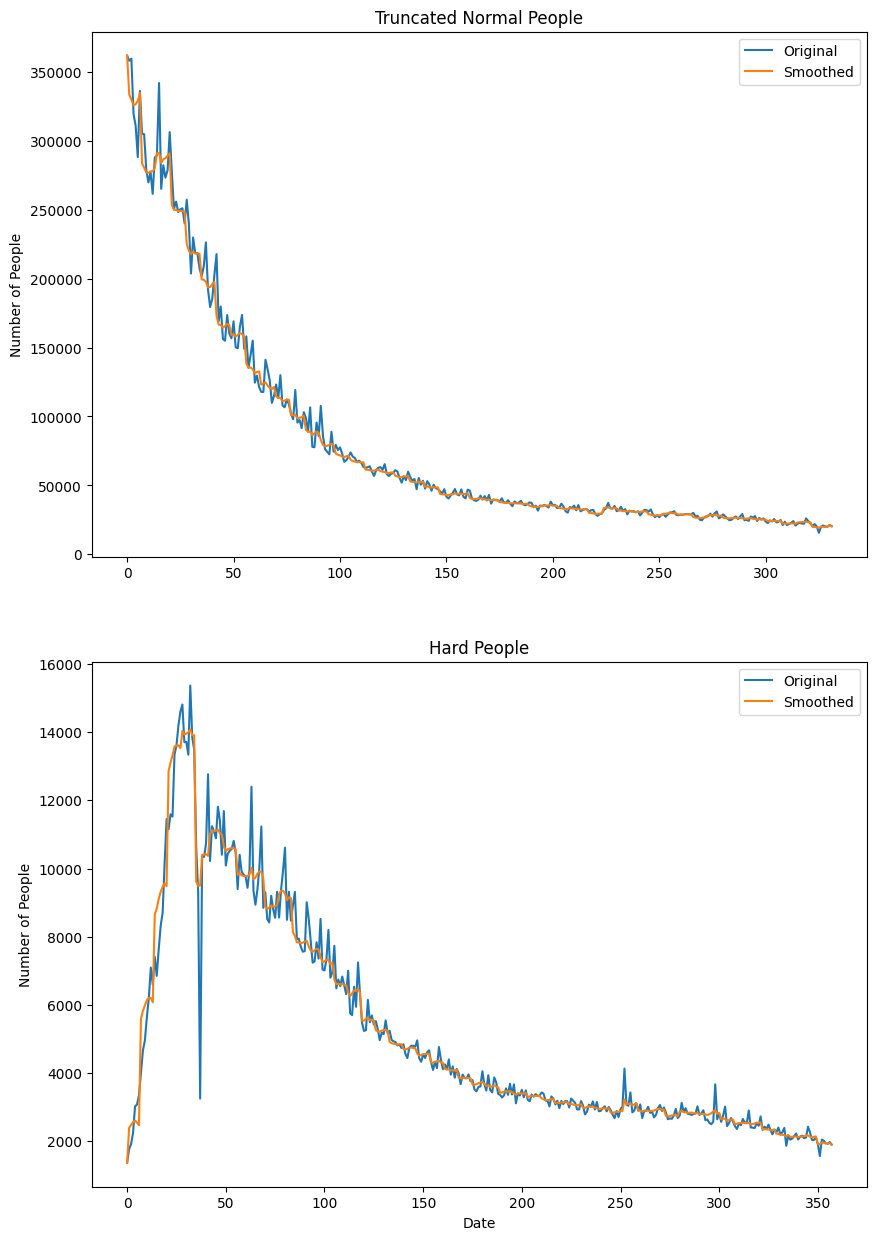

In [59]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import pywt

# Smooth Methods
#define a LOWESS function
def lowess(data, smoothing_param = 0.1):
	smoothing_param = smoothing_param
	lowess_model = sm.nonparametric.lowess(data, range(len(data)), frac=smoothing_param)
	smoothed_data = lowess_model[:, 1]
	return smoothed_data

def lowess_partial(data,  start, end, smoothing_param = 0.1):
    smoothing_param = smoothing_param
    lowess_model = sm.nonparametric.lowess(data[start:end], range(start, end), frac=smoothing_param)
    smoothed_data = lowess_model[:, 1]
    return smoothed_data
    

# calculate IQR and remove outliers within the window size
def denoise(raw_data, days_per_week = 7):
    data = np.copy(raw_data)
    num_weeks = len(data) // days_per_week
    # use indices to calculate rather than to reshape
    # Find outliers and replace them with the nearest neighbor average
    for i in range(num_weeks):
        # Calculate the lower and upper quartiles
        q1 = np.percentile(data[i], 25)
        q3 = np.percentile(data[i], 75)
        
        # calculate the interquatile range
        iqr = q3 - q1
        
        #define the lower and upper bound
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        
        # Find the outliers and replace them with the nearest neighbor average
        for j in range(days_per_week):
            if data[i*days_per_week+j] < lower_bound or data[i*days_per_week + j] > upper_bound:
                # Find the indices of the nearest neighbors, add indices in same week into a list
                data[i*days_per_week+j] = np.mean(data[i*days_per_week:i*days_per_week+days_per_week])
    return data

# evaluate the fitness of the model
# smoothed_hard_ratio = lowess(hard_ratio, smoothing_param = 0.1)

smoothed_normal_people_list = denoise(truncated_people_list, days_per_week = 7)
smoothed_hard_people_list = denoise(hard_people_list, days_per_week = 7)
# smoothed_normal_people_list = lowess(truncated_people_list, smoothing_param = 0.025)
# smoothed_hard_people_list = lowess(hard_people_list, smoothing_param = 0.03)

# evaluate the fitness of the model
# rmse = math.sqrt(mean_squared_error(hard_ratio, smoothed_hard_ratio))
rmse_2 = math.sqrt(mean_squared_error(truncated_people_list, smoothed_normal_people_list))
rmse_3 = math.sqrt(mean_squared_error(hard_people_list, smoothed_hard_people_list))
# print(rmse)
print(rmse_2)
print(rmse_3)


fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(10, 15))
# ax1.plot(hard_ratio, label='Original')
# ax1.plot(smoothed_hard_ratio, label='Smoothed')
# ax1.title.set_text('Hard Ratio')
# ax1.set_ylabel('Ratio')
# ax1.legend()


ax2.plot(truncated_people_list, label='Original')
ax2.plot(smoothed_normal_people_list, label='Smoothed')
ax2.title.set_text('Truncated Normal People')
ax2.set_ylabel('Number of People')
ax2.legend()


ax3.plot(hard_people_list, label='Original')
ax3.plot(smoothed_hard_people_list, label='Smoothed')
ax3.title.set_text('Hard People')
ax3.set_xlabel('Date')
ax3.set_ylabel('Number of People')
ax3.legend()

fig.show()

> Curve fitted by Curve Fitter Toolbox of Matlab
# Time-based Prediction
* Curve1: Exponential
```
General model Exp2:
     f(x) = a*exp(b*x) + c*exp(d*x)
Coefficients (with 95% confidence bounds):
       a =   3.396e+05  (3.336e+05, 3.455e+05)
       b =    -0.01775  (-0.01844, -0.01706)
       c =   2.095e+04  (1.431e+04, 2.759e+04)
       d =   0.0004411  (-0.000681, 0.001563)

Goodness of fit:
  SSE: 1.299e+10
  R-square: 0.9938
  Adjusted R-square: 0.9937
  RMSE: 6293

```


* Curve2: Gaussian
```
General model Gauss2:<br>
     f(x) =  a1*exp(-((x-b1)/c1)^2) + a2*exp(-((x-b2)/c2)^2
Coefficients (with 95% confidence bounds)
       a1 =    3.92e+05  (2.334e+05, 5.507e+05)
       b1 =       -59.4  (-85.51, -33.3)
       c1 =       91.99  (75.36, 108.6)
       a2 =   2.485e+18  (-5.938e+21, 5.943e+21)
       b2 =  -1.435e+04  (-1.103e+06, 1.075e+06)
       c2 =        2578  (-9.363e+04, 9.879e+04)
Goodness of fit
  SSE: 9.625e+09
  R-square: 0.9954
  Adjusted R-square: 0.9953
  RMSE: 5434
```

In [67]:
# Curve1
def Curve_Exp(x, a = 3.396e+05 , b= -0.01775 , c=2.095e+04 , d=0.0004411 ):
	return a * np.exp(b * x) + c*np.exp(d*x)

# Curve2
def Curve_Gau(x, a1 = 3.92e+05, b1= -59.4, c1= 91.99, a2 = 2.485e+18, b2= -1.435e+04, c2=2578):
	return a1 * np.exp(-((x - b1)/c1)**2) + a2 * np.exp(-((x - b2)/c2)**2)



In [68]:
# Prediction the March/1/2023
# last day of in data is Dec/31/2022
day_offset = 31+28+1

day = day_offset + len(t)

num_player1 = Curve_Exp(day)
num_player2 = Curve_Gau(day)

print("The number of players on March/1/2023 is: ", num_player1, " and ", num_player2)

The number of players on March/1/2023 is:  25227.491748924505  and  15628.663828538334


/tmp/ipykernel_58852/3250308607.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


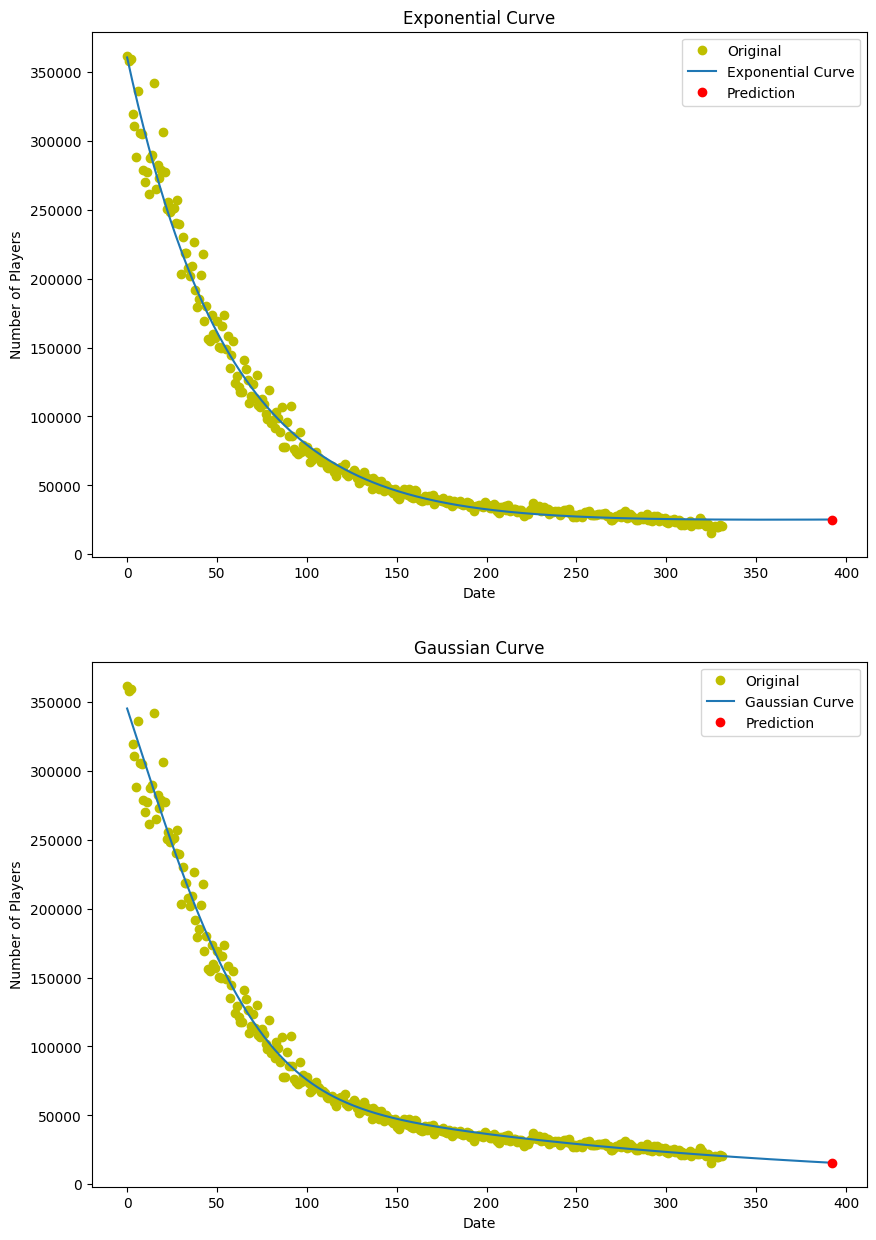

In [73]:
# Plot the curve and mark the point t = day
t_extend = np.arange(day)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))
# Exponential Curve
ax1.plot(t, truncated_people_list, 'yo', label='Original')
ax1.plot(t_extend, Curve_Exp(t_extend), label='Exponential Curve')
ax1.plot(day, num_player1, 'ro', label='Prediction')
ax1.title.set_text('Exponential Curve')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Players')
ax1.legend()

# Gaussian Curve
ax2.plot(t, truncated_people_list, 'yo', label='Original')
ax2.plot(t_extend, Curve_Gau(t_extend), label='Gaussian Curve')
ax2.plot(day, num_player2, 'ro', label='Prediction')
ax2.title.set_text('Gaussian Curve')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Players')
ax2.legend()

fig.show()
